In [ ]:
# !pip install dcor
# !pip install git+https://github.com/Shafi2016/pypdc_sis.git

In [ ]:
# # Load the dataset
# df = pd.read_csv('./official_data.csv')

# # Count the number of rows and columns
# rows, columns = df.shape

# rows, columns


# # Count the number of rows and columns excluding 'Date' and 'GDP' columns
# df_excluded = df.drop(columns=['date', 'GDP'], errors='ignore')

# rows_excluded, columns_excluded = df_excluded.shape

# rows_excluded, columns_excluded


In [ ]:
import pandas as pd
import numpy as np
from pypdc_sis import PDC_SIS

# Load the dataset


import logging


url1 = './gt_final.csv'
df = pd.read_csv(url1)

# Extract the GDP column and predictors from the first dataset
gdp = df['GDP']
data = df.iloc[:, 2:37]

# Creating lagged variables up to Lag 3
PredictLag3 = data.assign(**{
    f"{col}_lag{i}": data[col].shift(i) for i in range(1, 4) for col in data
}).reindex(columns=sorted(data.columns.tolist() + [f"{col}_lag{i}" for i in range(1, 4) for col in data], key=lambda x: (len(x), x)))

# Adjusting 'Xwl' to exclude rows with NAs introduced by lagging, ensuring alignment with 'Y'
Xwl = PredictLag3.dropna().to_numpy()

# Now, we need to adjust 'gdp' to match the number of rows in 'Xwl'
# Drop the same rows with NaNs in 'gdp' as those dropped in the predictors
Y = gdp[PredictLag3.notna().all(axis=1)].to_numpy()

# Check if the shapes of Xwl and Y match
print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# Apply the function (PDC_SIS)
results = PDC_SIS(Xwl, Y, lags=3, top_n=10)

# Retrieve the original names for the selected columns
selected_indices = results['indices']
original_column_names = PredictLag3.dropna().columns[selected_indices]

# Select the columns from PredictLag3 based on selected indices
selected_columns_df = PredictLag3[original_column_names]

# View the first few rows of the combined data frame
print(selected_columns_df.head())


Shape of Xwl: (209, 140), Shape of Y: (209,)
     online    rental    budget  real.estate      Audi  Farm...25_lag2  \
0 -0.018268  0.002117  0.006644    -0.024328 -0.248564             NaN   
1  0.008897 -0.023202  0.007350    -0.008379  0.033360             NaN   
2 -0.068661  0.065098 -0.016328    -0.040218  0.022182       -0.027108   
3  0.012436  0.016432  0.058863    -0.043077 -0.073964        0.145193   
4 -0.025900 -0.079472  0.058726    -0.015133  0.091555       -0.139514   

   Farm...15_lag2  Finance...30  Finance...11  travel_lag2  
0             NaN      0.099616      0.099616          NaN  
1             NaN     -0.078264     -0.078264          NaN  
2       -0.027108      0.014524      0.014524    -0.008840  
3        0.145193     -0.025331     -0.025331    -0.204636  
4       -0.139514     -0.156074     -0.156074     0.206149  


In [ ]:
### RF
### RF
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pypdc_sis import PDC_SIS  # Assuming this is the function you're using
from scipy.stats import mstats

### Part 1: Data Preparation
# Load the dataset
df = pd.read_csv('./gt_final.csv')

# Extracting the GDP column as the target variable 'Y'
gdp = df['GDP']

# Extracting the predictors
data = df.iloc[:, 2:37]

# Creating lagged variables up to Lag 3
PredictLag3 = data.assign(**{
    f"{col}_lag{i}": data[col].shift(i) for i in range(1, 4) for col in data
}).reindex(columns=sorted(data.columns.tolist() + [f"{col}_lag{i}" for i in range(1, 4) for col in data], key=lambda x: (len(x), x)))

# Create a mask for non-NA rows
mask = PredictLag3.notna().all(axis=1)

# Apply the mask consistently to both X and Y
Xwl = PredictLag3[mask].to_numpy()
Y = gdp[mask].to_numpy()

print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# Combine the date column with the predictors
dates = df['date'][mask].reset_index(drop=True)
Xwl_df = pd.DataFrame(Xwl, columns=PredictLag3.columns)
Xwl_df.insert(0, 'date', dates)

# Prepare the dataframe for rolling window analysis
df_combined = pd.concat([Xwl_df.reset_index(drop=True), pd.Series(Y, name='GDP')], axis=1)

def tune_and_fit(X_train, y_train, quick=True):
    """Train RF model - quick mode for inner loop efficiency."""
    if quick:
        # Simpler model for inner loop (faster)
        rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        return rf
    else:
        param_distributions = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        rf = RandomForestRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=rf, param_distributions=param_distributions,
            n_iter=10, cv=3, n_jobs=-1, random_state=42, scoring='neg_mean_squared_error'
        )
        random_search.fit(X_train, y_train)
        return random_search.best_estimator_


def OoS_R_sq_BaChu_style(df, tau, wsize, sstart, T1, ylag, sratio=0.80, quick_train=True):
    """
    Calculate rolling-window OoS performance for 'tau'-steps ahead forecasts.

    THIS MATCHES BA CHU'S H2O TECHNIQUE:
    - Inner rolling loop within each subsample
    - Each inner window trains a model and makes ONE tau-step ahead forecast
    - Metrics aggregated over all inner windows

    Parameters:
    -----------
    df: DataFrame with date, predictors, and GDP
    tau: forecast horizon
    wsize: rolling window size for training (Ba Chu uses 60)
    sstart: subsample starting point
    T1: size of subsample (Ba Chu uses 100)
    ylag: AR lag of dependent variable
    """
    assert (T1 > wsize + tau), "Size of subsample must be greater than window size + tau!"
    assert (sstart + T1 <= len(df)), "End point of subsample must be <= dataframe size!"

    # Extract subsample
    df_sub = df.iloc[sstart:(sstart + T1), :].copy()

    # Add lagged GDP if ylag > 0
    if ylag > 0:
        for i in range(1, ylag + 1):
            df_sub[f'ylag{i}'] = df_sub['GDP'].shift(i)
        df_sub.dropna(inplace=True)

    # Get features and target
    feature_columns = [c for c in df_sub.columns if c not in ['date', 'GDP']]

    R = df_sub['GDP'].values
    X = df_sub[feature_columns].values
    dates_sub = df_sub['date'].values

    T = len(R)
    dim = X.shape[1]

    # Number of inner rolling iterations (Ba Chu's formula)
    n_inner = T - wsize - tau

    if n_inner <= 0:
        raise ValueError(f"Not enough data for inner loop: T={T}, wsize={wsize}, tau={tau}, n_inner={n_inner}")

    print(f"  Subsample: T={T}, wsize={wsize}, tau={tau}, inner iterations={n_inner}")

    # Storage for errors and forecasts
    list_errors = []
    list_forecasts = []
    rmse_accum = 0
    var_accum = 0
    mae_accum = 0

    # =========================================================================
    # INNER ROLLING LOOP (matches Ba Chu's H2O structure)
    # =========================================================================
    for s in range(n_inner):
        # Training window: [s, s+wsize]
        X_train = X[s:(s + wsize), :]
        y_train = R[s:(s + wsize)]

        # Test point: s + wsize + tau (tau-step ahead of last training point)
        test_idx = s + wsize + tau - 1  # -1 because tau=1 means next point

        if test_idx >= T:
            break

        X_test = X[test_idx, :].reshape(1, -1)
        y_actual = R[test_idx]
        forecast_date = dates_sub[test_idx]

        # PDC-SIS feature selection on training window
        try:
            top_n_pdc_sis = min(8, X_train.shape[1])
            results = PDC_SIS(X_train, y_train, lags=3, top_n=top_n_pdc_sis)

            if 'indices' not in results or results['indices'] is None:
                # Fallback: use all features
                selected_indices = list(range(min(8, X_train.shape[1])))
            else:
                selected_indices = results['indices']
        except:
            # Fallback: use first 8 features
            selected_indices = list(range(min(8, X_train.shape[1])))

        # Select features
        X_train_sel = X_train[:, selected_indices]
        X_test_sel = X_test[:, selected_indices]

        # Train model and forecast
        try:
            model = tune_and_fit(X_train_sel, y_train, quick=quick_train)
            y_forecast = model.predict(X_test_sel)[0]
        except:
            # Fallback: use mean
            y_forecast = np.mean(y_train)

        # Calculate errors (Ba Chu's formulas)
        error = y_actual - y_forecast
        train_mean = np.mean(y_train)

        rmse_accum += (error ** 2) / n_inner
        var_accum += ((y_actual - train_mean) ** 2) / n_inner
        mae_accum += abs(error) / n_inner

        list_errors.append(error)
        list_forecasts.append({
            'date': forecast_date,
            'actual': y_actual,
            'predicted': y_forecast,
            'y_train_mean': train_mean,
            'inner_idx': s
        })

    # Calculate final metrics (Ba Chu's formulas)
    errors = np.array(list_errors)
    mad = robust.mad(errors, c=1)  # Median absolute deviation
    mae = mae_accum
    rmse = np.sqrt(rmse_accum)
    r_sq = 1 - rmse_accum / (var_accum + 0.00001)

    # Create forecasts dataframe
    forecasts_df = pd.DataFrame(list_forecasts)
    forecasts_df['sstart'] = sstart
    forecasts_df['window_end'] = df.iloc[sstart + T1 - 1]['date']

    return mad, mae, rmse, r_sq, forecasts_df


def OoS_R_sq_many_ssamples_BaChu_style(df, tau, step_size, wsize, T1, ylag, quick_train=True):
    """
    Calculate OoS metrics for many subsamples (outer loop).
    Matches Ba Chu's OoS_R_sq_many_ssamples function.
    """
    ssize = len(df) - ylag

    print(f"\n{'='*80}")
    print(f"Ba Chu Style Rolling Forecast")
    print(f"Sample size={ssize}, Subsample size={T1}, Window size={wsize}")
    print(f"AR lag={ylag}, Forecast horizon={tau}")
    print(f"{'='*80}")

    perf_dict = {
        'sstart': [],
        'ssample_start_date': [],
        'ssample_end_date': [],
        'mad': [],
        'mae': [],
        'rmse': [],
        'r_sq': []
    }

    all_forecasts = []

    for sstart in range(0, ssize + step_size, step_size):
        if sstart + T1 <= ssize:
            try:
                mad, mae, rmse, r_sq, forecasts_df = OoS_R_sq_BaChu_style(
                    df, tau, wsize, sstart, T1, ylag, quick_train=quick_train
                )

                print(f"sstart={sstart}: MAD={mad:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r_sq:.4f}")

                perf_dict['sstart'].append(sstart)
                perf_dict['ssample_start_date'].append(df.iloc[sstart]['date'])
                perf_dict['ssample_end_date'].append(df.iloc[sstart + T1 - 1]['date'])
                perf_dict['mad'].append(mad)
                perf_dict['mae'].append(mae)
                perf_dict['rmse'].append(rmse)
                perf_dict['r_sq'].append(r_sq)

                all_forecasts.append(forecasts_df)

            except Exception as e:
                print(f"Error at sstart={sstart}: {e}")

    # Combine all forecasts
    if all_forecasts:
        combined_forecasts = pd.concat(all_forecasts, ignore_index=True)
    else:
        combined_forecasts = None

    perf_df = pd.DataFrame(perf_dict)

    return perf_df, combined_forecasts


# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Parameters (matching Ba Chu's H2O settings)
wsize = 85   # Rolling window size (Ba Chu uses 60)
T1 = 100     # Subsample size (Ba Chu uses 100)
step_size = 1
ylag = 1

# Create output directory
output_dir = './OoS_metrics_rf_gt'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Forecast horizons
taus = [1, 3, 6, 9]

for tau in taus:
    print(f"\n{'='*80}")
    print(f"PROCESSING TAU = {tau}")
    print(f"{'='*80}")

    perf_df, forecasts_df = OoS_R_sq_many_ssamples_BaChu_style(
        df_combined, tau=tau, step_size=step_size,
        wsize=wsize, T1=T1, ylag=ylag, quick_train=True
    )

    # Save performance metrics (matches Ba Chu's output format)
    perf_df.to_csv(os.path.join(output_dir, f'OoS_metrics_tau_{tau}.csv'), index=False)

    # Save actual vs predicted (for rolling metrics calculation)
    if forecasts_df is not None:
        # Keep only one forecast per date (the tau-th step ahead)
        # Group by date and keep the last forecast for each date
        forecasts_unique = forecasts_df.drop_duplicates(subset='date', keep='last')
        forecasts_unique.to_csv(
            os.path.join(output_dir, f'actual_vs_predicted_tau_{tau}.csv'),
            index=False
        )
        print(f"\nSaved {len(forecasts_unique)} unique forecasts for tau={tau}")

    # Print summary
    print(f"\nSummary for tau={tau}:")
    print(f"  Median RMSE: {perf_df['rmse'].median():.4f}")
    print(f"  Median MAE: {perf_df['mae'].median():.4f}")
    print(f"  Median R²: {perf_df['r_sq'].median():.4f}")

print(f"\n{'='*80}")
print("COMPLETED!")
print(f"Results saved to: {output_dir}")
print(f"{'='*80}")

Shape of Xwl: (209, 140), Shape of Y: (209,)

PROCESSING TAU = 1

Ba Chu Style Rolling Forecast
Sample size=208, Subsample size=100, Window size=85
AR lag=1, Forecast horizon=1
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=0: MAD=0.0023, MAE=0.0025, RMSE=0.0031, R²=0.4292
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=3: MAD=0.0014, MAE=0.0022, RMSE=0.0026, R²=0.5163
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=6: MAD=0.0018, MAE=0.0024, RMSE=0.0029, R²=0.4591
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=9: MAD=0.0024, MAE=0.0022, RMSE=0.0027, R²=0.5303
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=12: MAD=0.0025, MAE=0.0027, RMSE=0.0032, R²=0.4448
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=15: MAD=0.0015, MAE=0.0029, RMSE=0.0033, R²=0.4633
  Subsample: T=99, wsize=85, tau=1, inner iterations=13
sstart=18: MAD=0.0024, MAE=0.0034, RMSE=0.0038, R²=0.3413
  Subsample: T=99, wsize=85, 

In [ ]:
## xgboost


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pypdc_sis import PDC_SIS  # Assuming this is the function you're using
from scipy.stats import mstats
import xgboost as xgb
### Part 1: Data Preparation

# Load the dataset
df = pd.read_csv('./gt_final.csv')

# Extracting the GDP column as the target variable 'Y'
gdp = df['GDP']

# Extracting the predictors
data = df.iloc[:, 2:37]

# Creating lagged variables up to Lag 3
PredictLag3 = data.assign(**{
    f"{col}_lag{i}": data[col].shift(i) for i in range(1, 4) for col in data
}).reindex(columns=sorted(data.columns.tolist() + [f"{col}_lag{i}" for i in range(1, 4) for col in data], key=lambda x: (len(x), x)))

# Create a mask for non-NA rows
mask = PredictLag3.notna().all(axis=1)

# Apply the mask consistently to both X and Y
Xwl = PredictLag3[mask].to_numpy()
Y = gdp[mask].to_numpy()

print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# Combine the date column with the predictors
dates = df['date'][mask].reset_index(drop=True)
Xwl_df = pd.DataFrame(Xwl, columns=PredictLag3.columns)
Xwl_df.insert(0, 'date', dates)

# Prepare the dataframe for rolling window analysis
df_combined = pd.concat([Xwl_df.reset_index(drop=True), pd.Series(Y, name='GDP')], axis=1)

from statsmodels import robust

def tune_and_fit(X_train, y_train, quick=True):
    """
    XGBoost trainer.
    quick=True is REQUIRED for inner-loop speed (like your RF script).
    """
    if quick:
        model = xgb.XGBRegressor(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        return model
    else:
        model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
        param_distributions = {
            "n_estimators": [200, 300, 500, 800],
            "max_depth": [3, 5, 7, 10],
            "learning_rate": [0.01, 0.03, 0.05, 0.1],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0],
        }
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=20,
            cv=3,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train, y_train)
        return random_search.best_estimator_


def OoS_R_sq_BaChu_style(df, tau, wsize, sstart, T1, ylag, quick_train=True):
    """
    Ba Chu / H2O-style evaluation for ONE subsample starting at sstart:
      - Inner rolling loop inside the subsample
      - Each inner loop trains on a window of length wsize and forecasts ONE point at horizon tau
      - Aggregate metrics across inner forecasts
    Outputs:
      mad, mae, rmse, r_sq, forecasts_df
    """
    assert (T1 > wsize + tau), "Size of subsample must be greater than window size + tau!"
    assert (sstart + T1 <= len(df)), "End point of subsample must be <= dataframe size!"

    df_sub = df.iloc[sstart:(sstart + T1), :].copy()

    # add lagged GDP (like RF script)
    if ylag > 0:
        for i in range(1, ylag + 1):
            df_sub[f"ylag{i}"] = df_sub["GDP"].shift(i)
        df_sub.dropna(inplace=True)

    feature_columns = [c for c in df_sub.columns if c not in ["date", "GDP"]]

    R = df_sub["GDP"].astype(float).values
    X = df_sub[feature_columns].astype(float).values
    dates_sub = df_sub["date"].values

    T = len(R)
    n_inner = T - wsize - tau
    if n_inner <= 0:
        raise ValueError(f"Not enough data for inner loop: T={T}, wsize={wsize}, tau={tau}, n_inner={n_inner}")

    list_errors = []
    list_forecasts = []

    rmse_accum = 0.0
    var_accum = 0.0
    mae_accum = 0.0

    for s in range(n_inner):
        # training window in FEATURES (time t = s ... s+wsize-1)
        X_train = X[s:(s + wsize), :]
        y_train = R[s:(s + wsize)]

        # forecast target index: tau steps ahead of last training point
        test_idx = s + wsize + tau - 1
        if test_idx >= T:
            break

        X_test = X[test_idx, :].reshape(1, -1)
        y_actual = R[test_idx]
        forecast_date = dates_sub[test_idx]

        # ===== Feature selection on the training window ONLY =====
        try:
            top_n = min(8, X_train.shape[1])
            sel = PDC_SIS(X_train, y_train, lags=3, top_n=top_n)

            if ("indices" not in sel) or (sel["indices"] is None):
                selected_indices = list(range(top_n))
            else:
                selected_indices = sel["indices"]
        except Exception:
            top_n = min(8, X_train.shape[1])
            selected_indices = list(range(top_n))

        X_train_sel = X_train[:, selected_indices]
        X_test_sel = X_test[:, selected_indices]

        # ===== Train + predict =====
        try:
            model = tune_and_fit(X_train_sel, y_train, quick=quick_train)
            y_forecast = float(model.predict(X_test_sel)[0])
        except Exception:
            y_forecast = float(np.mean(y_train))

        error = float(y_actual - y_forecast)
        train_mean = float(np.mean(y_train))

        # Ba Chu aggregation style (per-inner-step averaged)
        rmse_accum += (error ** 2) / n_inner
        var_accum += ((y_actual - train_mean) ** 2) / n_inner
        mae_accum += abs(error) / n_inner

        list_errors.append(error)
        list_forecasts.append({
            "date": forecast_date,
            "actual": float(y_actual),
            "predicted": float(y_forecast),
            "train_mean": train_mean,
            "inner_idx": s
        })

    errors = np.array(list_errors, dtype=float)

    mad = float(robust.mad(errors, c=1))               # like RF
    mae = float(mae_accum)
    rmse = float(np.sqrt(rmse_accum))

    # protect denom (same as your RF script)
    r_sq = float(1 - rmse_accum / (var_accum + 1e-5))

    forecasts_df = pd.DataFrame(list_forecasts)
    forecasts_df["sstart"] = sstart
    forecasts_df["window_end"] = df.iloc[sstart + T1 - 1]["date"]

    return mad, mae, rmse, r_sq, forecasts_df


def OoS_R_sq_many_ssamples_BaChu_style(df, tau, step_size, wsize, T1, ylag, quick_train=True):
    """
    Outer loop across subsamples (sstart), like your RF script.
    Returns:
      perf_df, combined_forecasts_df
    """
    ssize = len(df) - ylag

    perf_dict = {
        "sstart": [],
        "ssample_start_date": [],
        "ssample_end_date": [],
        "mad": [],
        "mae": [],
        "rmse": [],
        "r_sq": []
    }

    all_forecasts = []

    for sstart in range(0, ssize + step_size, step_size):
        if sstart + T1 <= ssize:
            try:
                mad, mae, rmse, r_sq, forecasts_df = OoS_R_sq_BaChu_style(
                    df, tau, wsize, sstart, T1, ylag, quick_train=quick_train
                )

                perf_dict["sstart"].append(sstart)
                perf_dict["ssample_start_date"].append(df.iloc[sstart]["date"])
                perf_dict["ssample_end_date"].append(df.iloc[sstart + T1 - 1]["date"])
                perf_dict["mad"].append(mad)
                perf_dict["mae"].append(mae)
                perf_dict["rmse"].append(rmse)
                perf_dict["r_sq"].append(r_sq)

                all_forecasts.append(forecasts_df)

            except Exception as e:
                print(f"Error at sstart={sstart}: {e}")

    perf_df = pd.DataFrame(perf_dict)

    if all_forecasts:
        combined_forecasts = pd.concat(all_forecasts, ignore_index=True)
    else:
        combined_forecasts = None

    return perf_df, combined_forecasts

# Parameters (match your RF-style evaluation)
wsize = 85
T1 = 100
step_size = 1
ylag = 1

output_dir = './OoS_metrics_xgboost_gt'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

taus = [1, 3, 6, 9]

for tau in taus:
    print(f"\n{'='*80}")
    print(f"PROCESSING TAU = {tau}")
    print(f"{'='*80}")

    perf_df, forecasts_df = OoS_R_sq_many_ssamples_BaChu_style(
        df_combined, tau=tau, step_size=step_size,
        wsize=wsize, T1=T1, ylag=ylag, quick_train=True
    )

    perf_df.to_csv(os.path.join(output_dir, f'OoS_metrics_tau_{tau}.csv'), index=False)

    if forecasts_df is not None:
        forecasts_unique = forecasts_df.drop_duplicates(subset='date', keep='last')
        forecasts_unique.to_csv(
            os.path.join(output_dir, f'actual_vs_predicted_tau_{tau}.csv'),
            index=False
        )
        print(f"Saved {len(forecasts_unique)} unique forecasts for tau={tau}")

    print(f"\nSummary for tau={tau}:")
    print(f"  Median RMSE: {perf_df['rmse'].median():.4f}")
    print(f"  Median MAE: {perf_df['mae'].median():.4f}")
    print(f"  Median R²: {perf_df['r_sq'].median():.4f}")



Shape of Xwl: (209, 140), Shape of Y: (209,)

PROCESSING TAU = 1
Saved 121 unique forecasts for tau=1

Summary for tau=1:
  Median RMSE: 0.0037
  Median MAE: 0.0029
  Median R²: 0.3377

PROCESSING TAU = 3
Saved 119 unique forecasts for tau=3

Summary for tau=3:
  Median RMSE: 0.0033
  Median MAE: 0.0026
  Median R²: 0.4217

PROCESSING TAU = 6
Saved 116 unique forecasts for tau=6

Summary for tau=6:
  Median RMSE: 0.0033
  Median MAE: 0.0027
  Median R²: 0.4104

PROCESSING TAU = 9
Saved 113 unique forecasts for tau=9

Summary for tau=9:
  Median RMSE: 0.0032
  Median MAE: 0.0029
  Median R²: 0.4451


In [ ]:
# !pip install catboost lightgbm


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pypdc_sis import PDC_SIS  # Assuming this is the function you're using
from scipy.stats import mstats
import catboost as cb
from joblib import Parallel, delayed
### Part 1: Data Preparation

# Load the dataset
df = pd.read_csv('./gt_final.csv')

# Extracting the GDP column as the target variable 'Y'
gdp = df['GDP']

# Extracting the predictors
data = df.iloc[:, 2:37]

# Creating lagged variables up to Lag 3
PredictLag3 = data.assign(**{
    f"{col}_lag{i}": data[col].shift(i) for i in range(1, 4) for col in data
}).reindex(columns=sorted(data.columns.tolist() + [f"{col}_lag{i}" for i in range(1, 4) for col in data], key=lambda x: (len(x), x)))

# Create a mask for non-NA rows
mask = PredictLag3.notna().all(axis=1)

# Apply the mask consistently to both X and Y
Xwl = PredictLag3[mask].to_numpy()
Y = gdp[mask].to_numpy()

print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# Combine the date column with the predictors
dates = df['date'][mask].reset_index(drop=True)
Xwl_df = pd.DataFrame(Xwl, columns=PredictLag3.columns)
Xwl_df.insert(0, 'date', dates)

# Prepare the dataframe for rolling window analysis
df_combined = pd.concat([Xwl_df.reset_index(drop=True), pd.Series(Y, name='GDP')], axis=1)

print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# ---------------------------
# LightGBM trainer (RF-style)
# ---------------------------
def tune_and_fit_lightgbm(X_train, y_train, quick=True):
    if quick:
        model = lgb.LGBMRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=-1,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        return model

    base = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    param_distributions = {
        "n_estimators": [200, 300, 500, 800, 1000],
        "learning_rate": [0.01, 0.03, 0.05, 0.1],
        "max_depth": [-1, 3, 5, 7, 10],
        "num_leaves": [15, 31, 63, 127],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "min_child_samples": [5, 10, 20, 40],
    }
    rs = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_distributions,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        random_state=42,
        scoring="neg_mean_squared_error"
    )
    rs.fit(X_train, y_train)
    return rs.best_estimator_


# ---------------------------
# OoS_R_sq (KEEP THIS NAME)
# RF-style inner rolling loop
# ---------------------------
def OoS_R_sq(df, tau, wsize, sstart, T1, ylag, sratio=0.80, quick_train=True):
    assert (T1 > wsize + tau), "T1 must be > wsize + tau!"
    assert (sstart + T1 <= len(df)), "sstart + T1 must be <= len(df)!"

    df_sub = df.iloc[sstart:(sstart + T1), :].copy()

    # Add lagged GDP if ylag > 0
    if ylag > 0:
        for i in range(1, ylag + 1):
            df_sub[f"ylag{i}"] = df_sub["GDP"].shift(i)
        df_sub.dropna(inplace=True)

    feature_columns = [c for c in df_sub.columns if c not in ["date", "GDP"]]

    R = df_sub["GDP"].values
    X = df_sub[feature_columns].values
    dates_sub = df_sub["date"].values

    T = len(R)
    n_inner = T - wsize - tau
    if n_inner <= 0:
        raise ValueError(f"Not enough data: T={T}, wsize={wsize}, tau={tau}, n_inner={n_inner}")

    list_errors = []
    list_forecasts = []
    rmse_accum = 0.0
    var_accum = 0.0
    mae_accum = 0.0

    for s in range(n_inner):
        X_train = X[s:(s + wsize), :]
        y_train = R[s:(s + wsize)]

        test_idx = s + wsize + tau - 1
        if test_idx >= T:
            break

        X_test = X[test_idx, :].reshape(1, -1)
        y_actual = float(R[test_idx])
        forecast_date = dates_sub[test_idx]

        # PDC-SIS
        try:
            top_n = min(8, X_train.shape[1])
            results = PDC_SIS(X_train, y_train, lags=3, top_n=top_n)
            selected_indices = results.get("indices", None)
            if selected_indices is None:
                selected_indices = list(range(min(8, X_train.shape[1])))
        except Exception:
            selected_indices = list(range(min(8, X_train.shape[1])))

        X_train_sel = X_train[:, selected_indices]
        X_test_sel = X_test[:, selected_indices]

        # Train + predict
        try:
            model = tune_and_fit_lightgbm(X_train_sel, y_train, quick=quick_train)
            y_forecast = float(model.predict(X_test_sel)[0])
        except Exception:
            y_forecast = float(np.mean(y_train))

        error = y_actual - y_forecast
        train_mean = float(np.mean(y_train))

        rmse_accum += (error ** 2) / n_inner
        var_accum += ((y_actual - train_mean) ** 2) / n_inner
        mae_accum += abs(error) / n_inner

        list_errors.append(error)
        list_forecasts.append({
            "date": forecast_date,
            "actual": y_actual,
            "predicted": y_forecast,
            "train_mean": train_mean,
            "inner_idx": int(s),
            "sstart": int(sstart),
            "window_end": df.iloc[sstart + T1 - 1]["date"]
        })

    errors = np.array(list_errors, dtype=float)
    mad = float(robust.mad(errors, c=1))
    mae = float(mae_accum)
    rmse = float(np.sqrt(rmse_accum))
    r_sq = float(1 - rmse_accum / (var_accum + 1e-5))

    forecasts_df = pd.DataFrame(list_forecasts)
    return mad, mae, rmse, r_sq, forecasts_df


# ---------------------------
# Outer loop (KEEP THIS NAME)
# ---------------------------
def OoS_R_sq_many_ssamples(df, tau, step_size, wsize, T1, ylag, sratio=0.80, quick_train=True):
    ssize = len(df) - ylag

    perf_dict = {
        "sstart": [],
        "ssample_start_date": [],
        "ssample_end_date": [],
        "mad": [],
        "mae": [],
        "rmse": [],
        "r_sq": []
    }

    all_forecasts = []

    for sstart in range(0, ssize + step_size, step_size):
        if sstart + T1 <= ssize:
            try:
                mad, mae, rmse, r_sq, forecasts_df = OoS_R_sq(
                    df, tau, wsize, sstart, T1, ylag, sratio=sratio, quick_train=quick_train
                )

                perf_dict["sstart"].append(sstart)
                perf_dict["ssample_start_date"].append(df.iloc[sstart]["date"])
                perf_dict["ssample_end_date"].append(df.iloc[sstart + T1 - 1]["date"])
                perf_dict["mad"].append(mad)
                perf_dict["mae"].append(mae)
                perf_dict["rmse"].append(rmse)
                perf_dict["r_sq"].append(r_sq)

                all_forecasts.append(forecasts_df)

                print(f"sstart={sstart}: MAD={mad:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r_sq:.4f}")

            except Exception as e:
                print(f"Error at sstart={sstart}: {e}")

    combined_forecasts = pd.concat(all_forecasts, ignore_index=True) if all_forecasts else None
    perf_df = pd.DataFrame(perf_dict)
    return perf_df, combined_forecasts


# ---------------------------
# MAIN
# ---------------------------
wsize = 85
T1 = 100
step_size = 1
ylag = 1

output_dir = "./OoS_metrics_LightGBM_gt"
os.makedirs(output_dir, exist_ok=True)

taus = [1, 3, 6, 9]

for tau in taus:
    print(f"\n{'='*80}\nPROCESSING TAU = {tau}\n{'='*80}")

    perf_df, forecasts_df = OoS_R_sq_many_ssamples(
        df_combined, tau=tau, step_size=step_size, wsize=wsize, T1=T1, ylag=ylag, quick_train=True
    )

    perf_df.to_csv(os.path.join(output_dir, f"OoS_metrics_tau_{tau}.csv"), index=False)

    if forecasts_df is not None:
        # match RF saving behavior
        forecasts_unique = forecasts_df.drop_duplicates(subset="date", keep="last")
        forecasts_unique.to_csv(
            os.path.join(output_dir, f"actual_vs_predicted_tau_{tau}.csv"),
            index=False
        )
        print(f"Saved {len(forecasts_unique)} unique forecasts for tau={tau}")

    print(f"\nSummary for tau={tau}:")
    print(f"  Median RMSE: {perf_df['rmse'].median():.4f}")
    print(f"  Median MAE:  {perf_df['mae'].median():.4f}")
    print(f"  Median R²:   {perf_df['r_sq'].median():.4f}")

print(f"\nCOMPLETED! Results saved to: {output_dir}")


Shape of Xwl: (209, 140), Shape of Y: (209,)
Shape of Xwl: (209, 140), Shape of Y: (209,)

PROCESSING TAU = 1


sstart=0: MAD=0.0014, MAE=0.0020, RMSE=0.0026, R²=0.5896
sstart=3: MAD=0.0012, MAE=0.0017, RMSE=0.0020, R²=0.7215
sstart=6: MAD=0.0015, MAE=0.0019, RMSE=0.0023, R²=0.6600
sstart=9: MAD=0.0017, MAE=0.0019, RMSE=0.0022, R²=0.6664
sstart=12: MAD=0.0022, MAE=0.0025, RMSE=0.0029, R²=0.5487
sstart=15: MAD=0.0014, MAE=0.0029, RMSE=0.0032, R²=0.4941
sstart=18: MAD=0.0018, MAE=0.0030, RMSE=0.0035, R²=0.4531
sstart=21: MAD=0.0017, MAE=0.0027, RMSE=0.0034, R²=0.4655
sstart=24: MAD=0.0019, MAE=0.0026, RMSE=0.0032, R²=0.5017
sstart=27: MAD=0.0017, MAE=0.0026, RMSE=0.0032, R²=0.4917
sstart=30: MAD=0.0016, MAE=0.0024, RMSE=0.0029, R²=0.5492
sstart=33: MAD=0.0021, MAE=0.0024, RMSE=0.0027, R²=0.5737
sstart=36: MAD=0.0013, MAE=0.0026, RMSE=0.0029, R²=0.5454
sstart=39: MAD=0.0026, MAE=0.0025, RMSE=0.0029, R²=0.5423
sstart=42: MAD=0.0017, MAE=0.0025, RMSE=0.0030, R²=0.5335
sstart=45: MAD=0.0026, MAE=0.0025, RMSE=0.0031, R²=0.5139
sstart=48: MAD=0.0025, MAE=0.0033, RMSE=0.0042, R²=0.3641
sstart=51: MAD=0.0

In [ ]:
## catboost

## catboost


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pypdc_sis import PDC_SIS  # Assuming this is the function you're using
from scipy.stats import mstats
import catboost as cb
from joblib import Parallel, delayed
### Part 1: Data Preparation

# Load the dataset
df = pd.read_csv('./gt_final.csv')

# Extracting the GDP column as the target variable 'Y'
gdp = df['GDP']

# Extracting the predictors
data = df.iloc[:, 2:37]

# Creating lagged variables up to Lag 3
PredictLag3 = data.assign(**{
    f"{col}_lag{i}": data[col].shift(i) for i in range(1, 4) for col in data
}).reindex(columns=sorted(data.columns.tolist() + [f"{col}_lag{i}" for i in range(1, 4) for col in data], key=lambda x: (len(x), x)))

# Create a mask for non-NA rows
mask = PredictLag3.notna().all(axis=1)

# Apply the mask consistently to both X and Y
Xwl = PredictLag3[mask].to_numpy()
Y = gdp[mask].to_numpy()

print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# Combine the date column with the predictors
dates = df['date'][mask].reset_index(drop=True)
Xwl_df = pd.DataFrame(Xwl, columns=PredictLag3.columns)
Xwl_df.insert(0, 'date', dates)

# Prepare the dataframe for rolling window analysis
df_combined = pd.concat([Xwl_df.reset_index(drop=True), pd.Series(Y, name='GDP')], axis=1)
# Function to train and fit RandomForest model with hyperparameter tuning using RandomizedSearchCV
def tune_and_fit_catboost(X_train, y_train, quick=True):
    """
    CatBoost model - quick mode for inner loop efficiency (like RF).
    """
    if quick:
        model = cb.CatBoostRegressor(
            iterations=400,
            depth=6,
            learning_rate=0.05,
            l2_leaf_reg=3,
            loss_function="RMSE",
            random_seed=42,
            verbose=False,
            allow_writing_files=False,
            thread_count=2
        )
        model.fit(X_train, y_train)
        return model

    # Full randomized search (slow; keep if you ever need it)
    base = cb.CatBoostRegressor(
        loss_function="RMSE",
        random_seed=42,
        verbose=False,
        allow_writing_files=False,
        thread_count=2
    )
    param_distributions = {
        "iterations": [200, 400, 600, 1000],
        "depth": [2, 4, 6, 8, 10],
        "learning_rate": [0.01, 0.03, 0.05, 0.1],
        "l2_leaf_reg": [1, 3, 5]
    }
    random_search = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_distributions,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=1,
        n_iter=25,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

from statsmodels import robust

def OoS_R_sq_BaChu_style_catboost(df, tau, wsize, sstart, T1, ylag, quick_train=True):
    """
    Ba Chu style:
    - Within each subsample, run an INNER rolling loop
    - For each inner loop: train on a rolling window and forecast ONE point at t+tau (using X at that target date, like your RF code)
    - Aggregate RMSE/MAE/MAD/R2 across inner windows
    """
    assert (T1 > wsize + tau), "Size of subsample must be greater than window size + tau!"
    assert (sstart + T1 <= len(df)), "End point of subsample must be <= dataframe size!"

    df_sub = df.iloc[sstart:(sstart + T1), :].copy()

    # Add lagged GDP if ylag > 0 (same as RF)
    if ylag > 0:
        for i in range(1, ylag + 1):
            df_sub[f"ylag{i}"] = df_sub["GDP"].shift(i)
        df_sub.dropna(inplace=True)

    feature_columns = [c for c in df_sub.columns if c not in ["date", "GDP"]]

    R = df_sub["GDP"].values.astype(float)
    X = df_sub[feature_columns].values.astype(float)
    dates_sub = df_sub["date"].values

    T = len(R)
    n_inner = T - wsize - tau
    if n_inner <= 0:
        raise ValueError(f"Not enough data for inner loop: T={T}, wsize={wsize}, tau={tau}, n_inner={n_inner}")

    list_errors = []
    list_forecasts = []
    rmse_accum = 0.0
    var_accum = 0.0
    mae_accum = 0.0

    for s in range(n_inner):
        # Train on [s, s+wsize)
        X_train = X[s:(s + wsize), :]
        y_train = R[s:(s + wsize)]

        # Test at s + wsize + tau - 1 (same indexing as your RF)
        test_idx = s + wsize + tau - 1
        if test_idx >= T:
            break

        X_test = X[test_idx, :].reshape(1, -1)
        y_actual = float(R[test_idx])
        forecast_date = dates_sub[test_idx]

        # PDC-SIS feature selection on training window
        try:
            top_n = min(8, X_train.shape[1])
            res = PDC_SIS(X_train, y_train, lags=3, top_n=top_n)
            if ("indices" not in res) or (res["indices"] is None):
                selected_indices = list(range(top_n))
            else:
                selected_indices = list(res["indices"])
        except Exception:
            selected_indices = list(range(min(8, X_train.shape[1])))

        X_train_sel = X_train[:, selected_indices]
        X_test_sel = X_test[:, selected_indices]

        # Train + predict
        try:
            model = tune_and_fit_catboost(X_train_sel, y_train, quick=quick_train)
            y_forecast = float(model.predict(X_test_sel)[0])
        except Exception:
            y_forecast = float(np.mean(y_train))

        error = y_actual - y_forecast
        train_mean = float(np.mean(y_train))

        rmse_accum += (error ** 2) / n_inner
        var_accum += ((y_actual - train_mean) ** 2) / n_inner
        mae_accum += abs(error) / n_inner

        list_errors.append(error)
        list_forecasts.append({
            "date": forecast_date,
            "actual": y_actual,
            "predicted": y_forecast,
            # include BOTH names so your rolling script never misses it
            "train_mean": train_mean,
            "y_train_mean": train_mean,
            "inner_idx": s
        })

    errors = np.asarray(list_errors, dtype=float)
    mad = float(robust.mad(errors, c=1))
    mae = float(mae_accum)
    rmse = float(np.sqrt(rmse_accum))

    # protect denom
    r_sq = float(1.0 - rmse_accum / (var_accum + 1e-8))

    forecasts_df = pd.DataFrame(list_forecasts)
    forecasts_df["sstart"] = sstart
    forecasts_df["window_end"] = df.iloc[sstart + T1 - 1]["date"]

    return mad, mae, rmse, r_sq, forecasts_df


def OoS_R_sq_many_ssamples_BaChu_style_catboost(df, tau, step_size, wsize, T1, ylag, quick_train=True):
    """
    Outer loop over subsamples (same structure as your RF)
    """
    ssize = len(df) - ylag

    perf_dict = {
        "sstart": [],
        "ssample_start_date": [],
        "ssample_end_date": [],
        "mad": [],
        "mae": [],
        "rmse": [],
        "r_sq": []
    }

    all_forecasts = []

    for sstart in range(0, ssize + step_size, step_size):
        if sstart + T1 <= ssize:
            try:
                mad, mae, rmse, r_sq, fdf = OoS_R_sq_BaChu_style_catboost(
                    df, tau, wsize, sstart, T1, ylag, quick_train=quick_train
                )

                perf_dict["sstart"].append(sstart)
                perf_dict["ssample_start_date"].append(df.iloc[sstart]["date"])
                perf_dict["ssample_end_date"].append(df.iloc[sstart + T1 - 1]["date"])
                perf_dict["mad"].append(mad)
                perf_dict["mae"].append(mae)
                perf_dict["rmse"].append(rmse)
                perf_dict["r_sq"].append(r_sq)

                all_forecasts.append(fdf)

            except Exception as e:
                print(f"Error at sstart={sstart}: {e}")

    perf_df = pd.DataFrame(perf_dict)
    combined_forecasts = pd.concat(all_forecasts, ignore_index=True) if all_forecasts else None
    return perf_df, combined_forecasts
# Parameters (match your RF/XGB updated protocol)
wsize = 85
T1 = 100
step_size = 1
ylag = 1

# === ADD HERE ===
output_dir = './OoS_metrics_catboost_gt'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# ================

taus = [1, 3, 6, 9]
results = {}

for tau in taus:
    print(f"\n{'='*80}")
    print(f"PROCESSING TAU = {tau}")
    print(f"{'='*80}")

    perf_df, forecasts_df = OoS_R_sq_many_ssamples_BaChu_style_catboost(
        df_combined, tau=tau, step_size=step_size,
        wsize=wsize, T1=T1, ylag=ylag, quick_train=True
    )
    results[tau] = perf_df

    perf_df.to_csv(os.path.join(output_dir, f"OoS_metrics_tau_{tau}.csv"), index=False)

    if forecasts_df is not None:
        # same saving logic as RF: keep unique dates
        forecasts_unique = forecasts_df.drop_duplicates(subset="date", keep="last")
        forecasts_unique.to_csv(
            os.path.join(output_dir, f"actual_vs_predicted_tau_{tau}.csv"),
            index=False
        )


Shape of Xwl: (209, 140), Shape of Y: (209,)

PROCESSING TAU = 1

PROCESSING TAU = 3

PROCESSING TAU = 6

PROCESSING TAU = 9


In [ ]:

## GBM

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from pypdc_sis import PDC_SIS  # Assuming this is the function you're using
from scipy.stats import mstats
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
### Part 1: Data Preparation

# Load the dataset
df = pd.read_csv('./gt_final.csv')

# Extracting the GDP column as the target variable 'Y'
gdp = df['GDP']

# Extracting the predictors
data = df.iloc[:, 2:99]

# Creating lagged variables up to Lag 3
PredictLag3 = data.assign(**{
    f"{col}_lag{i}": data[col].shift(i) for i in range(1, 4) for col in data
}).reindex(columns=sorted(data.columns.tolist() + [f"{col}_lag{i}" for i in range(1, 4) for col in data], key=lambda x: (len(x), x)))

# Create a mask for non-NA rows
mask = PredictLag3.notna().all(axis=1)

# Apply the mask consistently to both X and Y
Xwl = PredictLag3[mask].to_numpy()
Y = gdp[mask].to_numpy()

print(f"Shape of Xwl: {Xwl.shape}, Shape of Y: {Y.shape}")

# Combine the date column with the predictors
dates = df['date'][mask].reset_index(drop=True)
Xwl_df = pd.DataFrame(Xwl, columns=PredictLag3.columns)
Xwl_df.insert(0, 'date', dates)

# Prepare the dataframe for rolling window analysis
df_combined = pd.concat([Xwl_df.reset_index(drop=True), pd.Series(Y, name='GDP')], axis=1)
# Function to train and fit RandomForest model with hyperparameter tuning using RandomizedSearchCV
def tune_and_fit_gbm(X_train, y_train, quick=True):
    """
    RF-style trainer:
    - quick=True: fixed fast model for inner loop
    - quick=False: RandomizedSearchCV (slow)
    """
    if quick:
        gbm = GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            subsample=0.8,
            max_features=None,
            random_state=42
        )
        gbm.fit(X_train, y_train)
        return gbm

    gbm = GradientBoostingRegressor(random_state=42)
    param_distributions = {
        "n_estimators": [100, 200, 300, 500, 800],
        "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
        "max_depth": [2, 3, 4, 5],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "subsample": [0.6, 0.8, 1.0],
        "max_features": ["sqrt", "log2", None],
    }
    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_distributions,
        n_iter=20,
        cv=3,
        n_jobs=-1,
        random_state=42,
        scoring="neg_mean_squared_error"
    )
    rs.fit(X_train, y_train)
    return rs.best_estimator_

def OoS_R_sq(df, tau, wsize, sstart, T1, ylag, sratio=0.80, quick_train=True):
    """
    GBM version of UPDATED RF logic:
    - inner rolling loop inside each subsample
    - train on window of size wsize
    - forecast ONE tau-step-ahead point each inner step
    - aggregate rmse/mae/r2 same way as RF code
    """
    assert (T1 > wsize + tau), "T1 must be > wsize + tau!"
    assert (sstart + T1 <= len(df)), "sstart + T1 must be <= len(df)!"

    df_sub = df.iloc[sstart:(sstart + T1), :].copy()

    # Add lagged GDP if ylag > 0
    if ylag > 0:
        for i in range(1, ylag + 1):
            df_sub[f"ylag{i}"] = df_sub["GDP"].shift(i)
        df_sub.dropna(inplace=True)

    feature_columns = [c for c in df_sub.columns if c not in ["date", "GDP"]]

    R = df_sub["GDP"].values
    X = df_sub[feature_columns].values
    dates_sub = df_sub["date"].values

    T = len(R)
    n_inner = T - wsize - tau
    if n_inner <= 0:
        raise ValueError(f"Not enough data: T={T}, wsize={wsize}, tau={tau}, n_inner={n_inner}")

    list_errors = []
    list_forecasts = []
    rmse_accum = 0.0
    var_accum  = 0.0
    mae_accum  = 0.0

    for s in range(n_inner):
        # training window
        X_train = X[s:(s + wsize), :]
        y_train = R[s:(s + wsize)]

        # tau-step ahead test index (same as RF)
        test_idx = s + wsize + tau - 1
        if test_idx >= T:
            break

        X_test = X[test_idx, :].reshape(1, -1)
        y_actual = float(R[test_idx])
        forecast_date = dates_sub[test_idx]

        # PDC-SIS feature selection on training window
        try:
            top_n = min(8, X_train.shape[1])
            results = PDC_SIS(X_train, y_train, lags=3, top_n=top_n)
            selected_indices = results.get("indices", None)
            if selected_indices is None:
                selected_indices = list(range(min(8, X_train.shape[1])))
        except Exception:
            selected_indices = list(range(min(8, X_train.shape[1])))

        X_train_sel = X_train[:, selected_indices]
        X_test_sel  = X_test[:,  selected_indices]

        # train + forecast
        try:
            model = tune_and_fit_gbm(X_train_sel, y_train, quick=quick_train)
            y_forecast = float(model.predict(X_test_sel)[0])
        except Exception:
            y_forecast = float(np.mean(y_train))

        error = y_actual - y_forecast
        train_mean = float(np.mean(y_train))

        rmse_accum += (error ** 2) / n_inner
        var_accum  += ((y_actual - train_mean) ** 2) / n_inner
        mae_accum  += abs(error) / n_inner

        list_errors.append(error)
        list_forecasts.append({
            "date": forecast_date,
            "actual": y_actual,
            "predicted": y_forecast,
            "train_mean": train_mean,   # keep for downstream scripts
            "inner_idx": int(s),
            "sstart": int(sstart),
            "window_end": df.iloc[sstart + T1 - 1]["date"],
        })

    errors = np.array(list_errors, dtype=float)
    mad = float(robust.mad(errors, c=1))
    mae = float(mae_accum)
    rmse = float(np.sqrt(rmse_accum))
    r_sq = float(1 - rmse_accum / (var_accum + 1e-5))

    forecasts_df = pd.DataFrame(list_forecasts)
    return mad, mae, rmse, r_sq, forecasts_df


def OoS_R_sq_many_ssamples(df, tau, step_size, wsize, T1, ylag, sratio=0.80, quick_train=True):
    """
    Outer loop (same structure as RF updated):
    returns (perf_df, combined_forecasts)
    """
    ssize = len(df) - ylag

    perf_dict = {
        "sstart": [],
        "ssample_start_date": [],
        "ssample_end_date": [],
        "mad": [],
        "mae": [],
        "rmse": [],
        "r_sq": []
    }

    all_forecasts = []

    for sstart in range(0, ssize + step_size, step_size):
        if sstart + T1 <= ssize:
            try:
                mad, mae, rmse, r_sq, forecasts_df = OoS_R_sq(
                    df, tau, wsize, sstart, T1, ylag, sratio=sratio, quick_train=quick_train
                )

                perf_dict["sstart"].append(sstart)
                perf_dict["ssample_start_date"].append(df.iloc[sstart]["date"])
                perf_dict["ssample_end_date"].append(df.iloc[sstart + T1 - 1]["date"])
                perf_dict["mad"].append(mad)
                perf_dict["mae"].append(mae)
                perf_dict["rmse"].append(rmse)
                perf_dict["r_sq"].append(r_sq)

                all_forecasts.append(forecasts_df)

                print(f"sstart={sstart}: MAD={mad:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r_sq:.4f}")

            except Exception as e:
                print(f"Error at sstart={sstart}: {e}")

    perf_df = pd.DataFrame(perf_dict)
    combined_forecasts = pd.concat(all_forecasts, ignore_index=True) if all_forecasts else None
    return perf_df, combined_forecasts



# Define parameters
wsize = 85
T1 = 100
step_size = 1
ylag = 1

output_dir = "./OoS_metrics_GBM_gt"
os.makedirs(output_dir, exist_ok=True)

taus = [1, 3, 6, 9]

for tau in taus:
    print(f"\n{'='*80}\nPROCESSING TAU = {tau}\n{'='*80}")

    perf_df, forecasts_df = OoS_R_sq_many_ssamples(
        df_combined,
        tau=tau,
        step_size=step_size,
        wsize=wsize,
        T1=T1,
        ylag=ylag,
        quick_train=True
    )

    perf_df.to_csv(os.path.join(output_dir, f"OoS_metrics_tau_{tau}.csv"), index=False)

    if forecasts_df is not None:
        forecasts_unique = forecasts_df.drop_duplicates(subset="date", keep="last")
        forecasts_unique.to_csv(
            os.path.join(output_dir, f"actual_vs_predicted_tau_{tau}.csv"),
            index=False
        )
        print(f"Saved {len(forecasts_unique)} unique forecasts for tau={tau}")

    print(f"\nSummary for tau={tau}:")
    print(f"  Median RMSE: {perf_df['rmse'].median():.4f}")
    print(f"  Median MAE:  {perf_df['mae'].median():.4f}")
    print(f"  Median R²:   {perf_df['r_sq'].median():.4f}")


Shape of Xwl: (209, 144), Shape of Y: (209,)

PROCESSING TAU = 1
sstart=0: MAD=0.0014, MAE=0.0029, RMSE=0.0036, R²=0.2484
sstart=3: MAD=0.0026, MAE=0.0024, RMSE=0.0026, R²=0.5047
sstart=6: MAD=0.0021, MAE=0.0024, RMSE=0.0028, R²=0.4724
sstart=9: MAD=0.0017, MAE=0.0022, RMSE=0.0026, R²=0.5463
sstart=12: MAD=0.0016, MAE=0.0025, RMSE=0.0030, R²=0.4975
sstart=15: MAD=0.0014, MAE=0.0028, RMSE=0.0033, R²=0.4754
sstart=18: MAD=0.0020, MAE=0.0033, RMSE=0.0039, R²=0.3130
sstart=21: MAD=0.0029, MAE=0.0030, RMSE=0.0037, R²=0.3677
sstart=24: MAD=0.0024, MAE=0.0025, RMSE=0.0033, R²=0.4648
sstart=27: MAD=0.0023, MAE=0.0025, RMSE=0.0032, R²=0.4807
sstart=30: MAD=0.0022, MAE=0.0023, RMSE=0.0032, R²=0.4473
sstart=33: MAD=0.0020, MAE=0.0029, RMSE=0.0036, R²=0.2373
sstart=36: MAD=0.0022, MAE=0.0032, RMSE=0.0036, R²=0.2748
sstart=39: MAD=0.0027, MAE=0.0032, RMSE=0.0040, R²=0.1402
sstart=42: MAD=0.0020, MAE=0.0028, RMSE=0.0038, R²=0.2494
sstart=45: MAD=0.0021, MAE=0.0028, RMSE=0.0037, R²=0.3033
sstart=48: 

AR/ARIMA forecast files found for all taus. Skipping generation.
Loaded (one/date): CatBoost tau=1, points=121
Loaded (one/date): CatBoost tau=3, points=119
Loaded (one/date): CatBoost tau=6, points=116
Loaded (one/date): CatBoost tau=9, points=113
Loaded (one/date): LightGBM tau=1, points=121
Loaded (one/date): LightGBM tau=3, points=119
Loaded (one/date): LightGBM tau=6, points=116
Loaded (one/date): LightGBM tau=9, points=113
Loaded (one/date): Random Forest tau=1, points=121
Loaded (one/date): Random Forest tau=3, points=119
Loaded (one/date): Random Forest tau=6, points=116
Loaded (one/date): Random Forest tau=9, points=113
Loaded (one/date): GBM tau=1, points=121
Loaded (one/date): GBM tau=3, points=119
Loaded (one/date): GBM tau=6, points=116
Loaded (one/date): GBM tau=9, points=113
Loaded (one/date): XGBoost tau=1, points=121
Loaded (one/date): XGBoost tau=3, points=119
Loaded (one/date): XGBoost tau=6, points=116
Loaded (one/date): XGBoost tau=9, points=113
Loaded (one/date): 

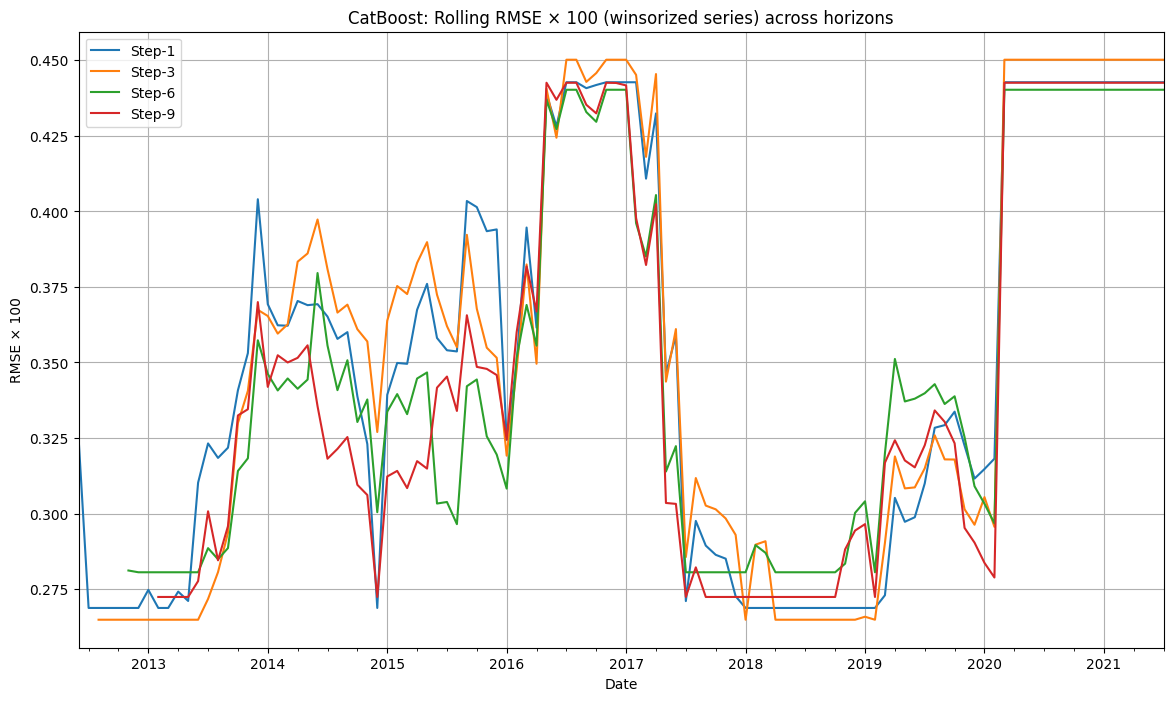

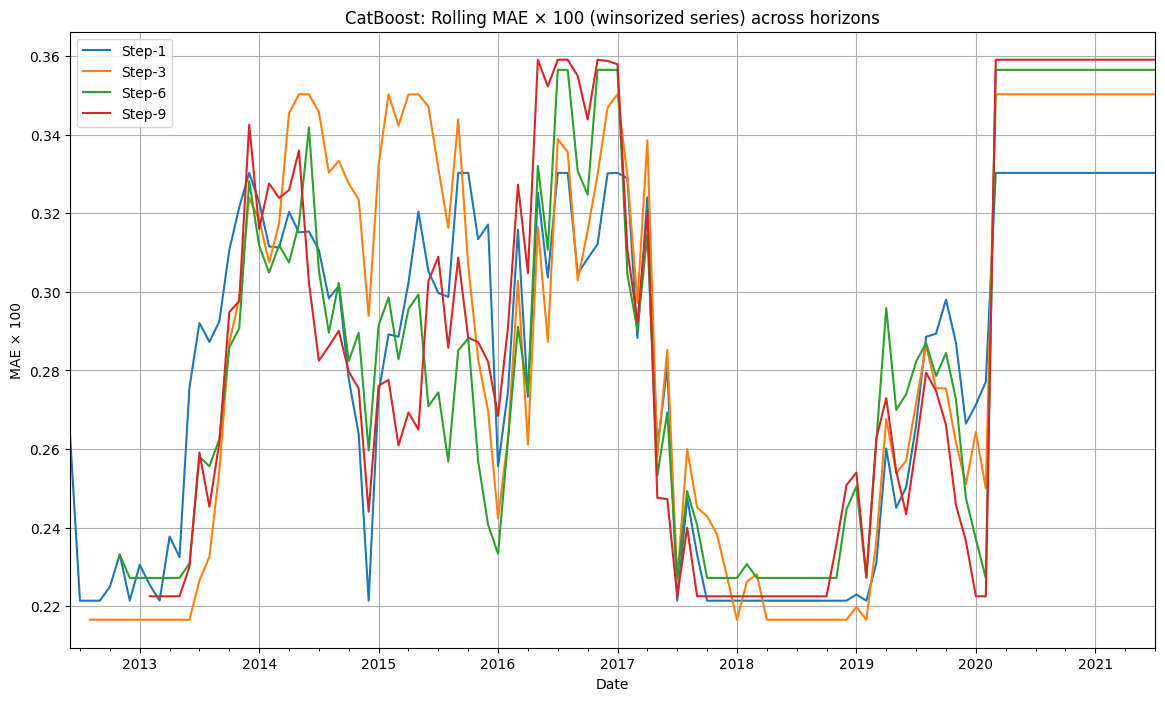

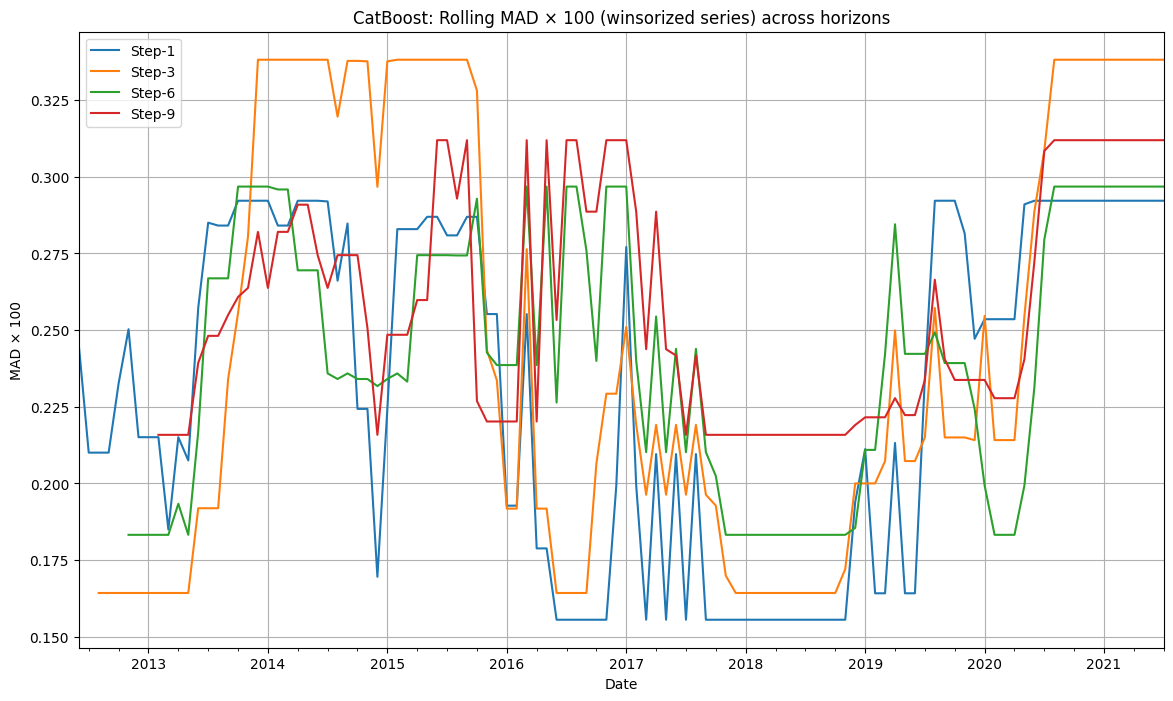

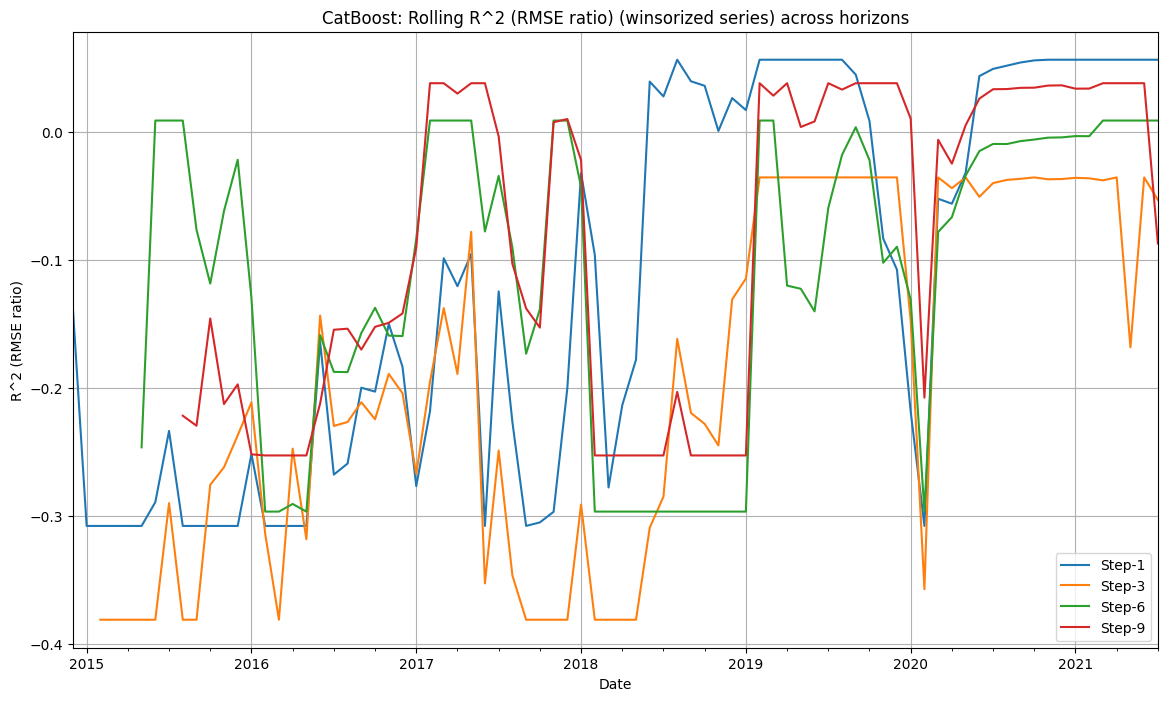

Saved: rmse_tau_1.png
Saved: mae_tau_1.png
Saved: mad_tau_1.png
Saved: r_sq_tau_1.png
Saved: rmse_tau_3.png
Saved: mae_tau_3.png
Saved: mad_tau_3.png
Saved: r_sq_tau_3.png
Saved: rmse_tau_6.png
Saved: mae_tau_6.png
Saved: mad_tau_6.png
Saved: r_sq_tau_6.png
Saved: rmse_tau_9.png
Saved: mae_tau_9.png
Saved: mad_tau_9.png
Saved: r_sq_tau_9.png

FINAL SUMMARY — Rolling RMSE/MAE/MAD (×100) + Rolling R^2 (RMSE ratio benchmark)
Rolling window size: 12 | Benchmark window: 30 | Align dates across models: True

--- Horizon h=1 ---
Model           RMSE×100       (IQR)          MAE×100        (IQR)          MAD×100        (IQR)          R²             (IQR)          N    
----------------------------------------------------------------------------------------------------------------------------------
AR              0.3065         0.1422         0.2506         0.1193         0.1918         0.0871         0.0389         0.2147         110  
ARIMA           0.3064         0.1422         0.2506     

In [ ]:
# ======================================================================================
# Script 1 (Corrected) — Rolling RMSE/MAE/MAD + Rolling R^2 using RMSE ratio benchmark
# Keeps your paper-ready structure (tables + graphs + CSV outputs) and adds AR/ARIMA.
#
# KEY FIX:
#   - actual_vs_predicted files contain MANY duplicated target dates (stacked over sstart/inner_idx).
#   - Rolling metrics must be computed on a proper time series => ONE forecast per target date.
#   - We collapse to ONE forecast per date (latest-origin proxy) before rolling.
#
# R^2 DEFINITION (as requested):
#   R2 = 1 - (RMSE_model / RMSE_benchmark)^2   computed on rolling RMSE series.
#
# ======================================================================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mstats
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# =========================
# CONFIG (EDIT THIS PATH)
# =========================
base_path = r"C:\Users\shafiullah.qureshi\OneDrive - Government of Alberta\Documents\nowcast_gdp\Dynamic Feature Selection for Canadian GDP"
DATA_FILE = os.path.join(base_path, "official_data.csv")

# Where your models already write outputs
model_folders = [
    (os.path.join(base_path, "OoS_metrics_Catboost_gt"), "CatBoost"),
    (os.path.join(base_path, "OoS_metrics_LightGBM_gt"), "LightGBM"),
    (os.path.join(base_path, "OoS_metrics_rf_gt"), "Random Forest"),
    (os.path.join(base_path, "OoS_metrics_GBM_gt"), "GBM"),
    (os.path.join(base_path, "OoS_metrics_xgboost_gt"), "XGBoost"),
]

# Add AR/ARIMA folders (will read from these; can generate if missing)
# AR_FOLDER    = os.path.join(base_path, "OoS_metrics_AR_gt")
ARIMA_FOLDER = os.path.join(base_path, "OoS_metrics_ARIMA_gt")

# Output folder for paper tables/graphs (same as your script)
output_folder = os.path.join(base_path, "graph_pdc_gt")
os.makedirs(output_folder, exist_ok=True)

# Horizons
taus = [1, 3, 6, 9]

# Rolling settings (paper)
ROLLING_WINDOW = 12      # rolling window for RMSE/MAE/MAD and for RMSE-based R^2
ROLLMEAN_WINDOW = 30     # benchmark forecast = rolling mean of actual (t-1 backward-looking)

# Reporting scale for error metrics in the rolling-table (your earlier table used "×10")
ERR_SCALE = 100.0         # set to 100.0 if you want ×100 instead
WINSOR_LIMITS = (0.20, 0.20)

# IMPORTANT: fair comparison across models
ALIGN_DATES_ACROSS_MODELS = True   # ensures same target dates per horizon for all models

# For line charts (keep your Script-1 style: one model with lines across horizons)
LINE_PLOT_MODEL = "CatBoost"

# If AR/ARIMA forecast files are missing, generate them here (can be heavy if you re-run)
GENERATE_AR_ARIMA_IF_MISSING = True

# Subsample protocol for AR/ARIMA generation (must match your RF-style evaluation)
T1 = 100
step_size = 1
WSIZE_TRAIN = 85
YLAG = 1

# AR selection
AR_MAX_LAG = 8

# ARIMA order selection (small grid; order chosen once per tau)
ARIMA_GRID_P_MAX = 2
ARIMA_GRID_Q_MAX = 2
ARIMA_D_OPTS = (0, 1)
ARIMA_MAXITER = 50

# =========================
# COLORS (paper figures)
# =========================
custom_colors = {
    "CatBoost": "blue",
    "LightGBM": "green",
    "Random Forest": "orange",
    "GBM": "purple",
    "XGBoost": "pink",
    "AR": "black",
    "ARIMA": "red",
}

# =========================
# HELPERS
# =========================
def winsorize_data(x, limits=WINSOR_LIMITS):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([], dtype=float)
    return np.asarray(mstats.winsorize(x, limits=limits), dtype=float)

def find_med(x):
    x = np.asarray(x, dtype=float)
    return float(np.percentile(x, 50)) if x.size else np.nan

def find_iqr(x):
    x = np.asarray(x, dtype=float)
    return float(np.percentile(x, 75) - np.percentile(x, 25)) if x.size else np.nan

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

# =========================
# LOAD + COLLAPSE FORECASTS
# =========================
def load_one_forecast_per_date(avp_file: str) -> pd.DataFrame:
    """
    Reads actual_vs_predicted_tau_k.csv and collapses to ONE forecast per target date.

    Why:
      actual_vs_predicted contains stacked forecasts from many overlapping subsamples.
      Rolling(12) on stacked rows is NOT a time-series rolling metric.

    Rule used (latest-origin proxy):
      for each target date, keep the row with the largest (sstart, inner_idx) available.
    """
    df = pd.read_csv(avp_file)

    if "date" not in df.columns:
        raise ValueError(f"'date' column missing in {avp_file}")

    df["date"] = pd.to_datetime(df["date"])
    # Make sure these exist; if not, create fallbacks
    if "sstart" not in df.columns:
        df["sstart"] = 0
    if "inner_idx" not in df.columns:
        df["inner_idx"] = np.arange(len(df))

    # sort so last row per date is "latest"
    df = df.sort_values(["date", "sstart", "inner_idx"]).reset_index(drop=True)

    # keep last (latest) per date
    one = df.groupby("date", as_index=False).tail(1).reset_index(drop=True)

    # enforce numeric
    one["actual"] = pd.to_numeric(one["actual"], errors="coerce")
    one["predicted"] = pd.to_numeric(one["predicted"], errors="coerce")
    one = one.dropna(subset=["actual", "predicted"]).reset_index(drop=True)

    # set index for time-series rolling
    one = one.sort_values("date").reset_index(drop=True)
    return one

# =========================
# ROLLING METRICS (per model/tau)
# =========================
def compute_rolling_metrics(one_df: pd.DataFrame):
    """
    one_df: one forecast per target date (sorted by date), with columns: date, actual, predicted
    Returns:
      rolling_rmse_scaled (Series), rolling_mae_scaled (Series), rolling_mad_scaled (Series),
      rolling_r2 (Series) computed as 1 - (RMSE_model / RMSE_bench)^2
    """
    s = one_df.copy()
    s = s.sort_values("date").reset_index(drop=True)
    s = s.set_index("date")

    actual = s["actual"].astype(float)
    pred = s["predicted"].astype(float)
    err = actual - pred

    # Rolling RMSE/MAE/MAD (scaled for reporting)
    rmse_raw = np.sqrt((err ** 2).rolling(ROLLING_WINDOW).mean())
    mae_raw = (err.abs()).rolling(ROLLING_WINDOW).mean()
    mad_raw = (err.abs()).rolling(ROLLING_WINDOW).median()

    rmse_scaled = ERR_SCALE * rmse_raw
    mae_scaled = ERR_SCALE * mae_raw
    mad_scaled = ERR_SCALE * mad_raw

    # Benchmark: rolling mean forecast using ONLY past actual values (shift(1))
    bench_pred = actual.shift(1).rolling(ROLLMEAN_WINDOW, min_periods=ROLLMEAN_WINDOW).mean()
    bench_err = actual - bench_pred
    bench_rmse_raw = np.sqrt((bench_err ** 2).rolling(ROLLING_WINDOW).mean())

    # Align indices for ratio
    aligned = pd.concat([rmse_raw, bench_rmse_raw], axis=1)
    aligned.columns = ["rmse_model", "rmse_bench"]
    aligned = aligned.dropna()

    # R^2 = 1 - (RMSE_model/RMSE_bench)^2
    den = aligned["rmse_bench"].replace(0.0, np.nan)
    r2 = 1.0 - (aligned["rmse_model"] / den) ** 2
    r2 = r2.replace([np.inf, -np.inf], np.nan).dropna()

    # dropna on scaled metrics too (for same “rolling points” concept)
    rmse_scaled = rmse_scaled.dropna()
    mae_scaled = mae_scaled.dropna()
    mad_scaled = mad_scaled.dropna()

    return rmse_scaled, mae_scaled, mad_scaled, r2

# =========================
# OPTIONAL: GENERATE AR/ARIMA FORECAST FILES (if missing)
# =========================
def select_ar_lag_aic(y, max_lag=8):
    y = pd.Series(y).astype(float)
    best_aic = np.inf
    best_lag = 1
    max_lag_eff = max(1, min(max_lag, len(y) - 2))
    for lag in range(1, max_lag_eff + 1):
        try:
            res = AutoReg(y, lags=lag, trend="c", old_names=False).fit()
            if np.isfinite(res.aic) and res.aic < best_aic:
                best_aic = res.aic
                best_lag = lag
        except Exception:
            continue
    return best_lag

def select_arima_order_aic(y, p_max=2, q_max=2, d_opts=(0, 1)):
    y = pd.Series(y).astype(float)
    best_aic = np.inf
    best_order = (1, 0, 0)
    for p in range(p_max + 1):
        for d in d_opts:
            for q in range(q_max + 1):
                if (p, d, q) == (0, 0, 0):
                    continue
                try:
                    trend = "c" if d == 0 else "n"
                    res = ARIMA(
                        y,
                        order=(p, d, q),
                        trend=trend,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit(method_kwargs={"maxiter": ARIMA_MAXITER})
                    if np.isfinite(res.aic) and res.aic < best_aic:
                        best_aic = res.aic
                        best_order = (p, d, q)
                except Exception:
                    continue
    return best_order

def generate_ar_arima_files_if_missing():
    ensure_dir(AR_FOLDER)
    ensure_dir(ARIMA_FOLDER)

    df = pd.read_csv(DATA_FILE)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    max_sstart = len(df) - T1
    if max_sstart < 0:
        raise ValueError(f"Not enough rows for T1={T1}. len(df)={len(df)}")

    # Check if any AR/ARIMA avp missing; if none missing, skip generation
    missing_any = False
    for tau in taus:
        ar_avp = os.path.join(AR_FOLDER, f"actual_vs_predicted_tau_{tau}.csv")
        arima_avp = os.path.join(ARIMA_FOLDER, f"actual_vs_predicted_tau_{tau}.csv")
        if not (os.path.exists(ar_avp) and os.path.exists(arima_avp)):
            missing_any = True
            break
    if not missing_any:
        print("AR/ARIMA forecast files found for all taus. Skipping generation.")
        return

    print("Generating AR/ARIMA forecast files (only because some are missing)...")

    for tau in taus:
        # choose lag/order once per tau on first subsample first training window
        first_sub = df.iloc[0:T1].copy().reset_index(drop=True)
        if YLAG > 0:
            for i in range(1, YLAG + 1):
                first_sub[f"ylag{i}"] = first_sub["GDP"].shift(i)
            first_sub = first_sub.dropna().reset_index(drop=True)

        y0 = first_sub["GDP"].astype(float).values
        y_train0 = y0[0:WSIZE_TRAIN]

        ar_lag_tau = select_ar_lag_aic(y_train0, max_lag=AR_MAX_LAG)
        arima_order_tau = select_arima_order_aic(
            y_train0, p_max=ARIMA_GRID_P_MAX, q_max=ARIMA_GRID_Q_MAX, d_opts=ARIMA_D_OPTS
        )

        print(f"[tau={tau}] AR lag: {ar_lag_tau} | ARIMA order: {arima_order_tau}")

        ar_rows = []
        arima_rows = []

        for sstart in range(0, max_sstart + 1, step_size):
            sub = df.iloc[sstart:sstart + T1].copy().reset_index(drop=True)

            if YLAG > 0:
                for i in range(1, YLAG + 1):
                    sub[f"ylag{i}"] = sub["GDP"].shift(i)
                sub = sub.dropna().reset_index(drop=True)

            dates_sub = sub["date"].values
            y = sub["GDP"].astype(float).values
            T = len(y)

            n_inner = T - WSIZE_TRAIN - tau
            if n_inner <= 0:
                continue

            for inner_idx in range(n_inner):
                origin_idx = inner_idx + WSIZE_TRAIN - 1
                target_idx = origin_idx + tau
                if target_idx >= T:
                    break

                y_train = y[inner_idx:inner_idx + WSIZE_TRAIN]
                train_mean = float(np.mean(y_train))

                target_date = pd.to_datetime(dates_sub[target_idx])
                y_actual = float(y[target_idx])

                # AR
                try:
                    lag_eff = min(ar_lag_tau, max(1, len(y_train) - 2))
                    ar_res = AutoReg(y_train, lags=lag_eff, trend="c", old_names=False).fit()
                    ar_fc = ar_res.predict(start=len(y_train), end=len(y_train) + tau - 1)
                    y_hat_ar = float(ar_fc[-1])
                except Exception:
                    y_hat_ar = train_mean

                ar_rows.append({
                    "date": target_date,
                    "actual": y_actual,
                    "predicted": y_hat_ar,
                    "sstart": int(sstart),
                    "inner_idx": int(inner_idx),
                })

                # ARIMA
                try:
                    p, d, q = arima_order_tau
                    trend = "c" if d == 0 else "n"
                    res = ARIMA(
                        y_train,
                        order=arima_order_tau,
                        trend=trend,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    ).fit(method_kwargs={"maxiter": ARIMA_MAXITER})
                    fc = res.forecast(steps=tau)
                    y_hat_arima = float(fc.iloc[-1] if hasattr(fc, "iloc") else fc[-1])
                except Exception:
                    y_hat_arima = train_mean

                arima_rows.append({
                    "date": target_date,
                    "actual": y_actual,
                    "predicted": y_hat_arima,
                    "sstart": int(sstart),
                    "inner_idx": int(inner_idx),
                })

        # save
        ar_df = pd.DataFrame(ar_rows)
        arima_df = pd.DataFrame(arima_rows)

        ar_df.to_csv(os.path.join(AR_FOLDER, f"actual_vs_predicted_tau_{tau}.csv"), index=False)
        arima_df.to_csv(os.path.join(ARIMA_FOLDER, f"actual_vs_predicted_tau_{tau}.csv"), index=False)

        print(f"Saved AR avp:    tau={tau}, rows={len(ar_df)}")
        print(f"Saved ARIMA avp: tau={tau}, rows={len(arima_df)}")

# =========================
# MAIN EVALUATION (SCRIPT-1 STYLE)
# =========================

if GENERATE_AR_ARIMA_IF_MISSING:
    generate_ar_arima_files_if_missing()

# Extend folders with AR/ARIMA
extended_folders = model_folders + [
    (AR_FOLDER, "AR"),
    (ARIMA_FOLDER, "ARIMA"),
]

# Storage (paper tables + plots)
all_metrics_data = []
all_rolling_rmse_data = {m: {} for _, m in extended_folders}
all_rolling_mae_data  = {m: {} for _, m in extended_folders}
all_rolling_mad_data  = {m: {} for _, m in extended_folders}
all_rolling_r2_data   = {m: {} for _, m in extended_folders}

# Pre-load ONE-FORECAST-PER-DATE series to optionally align dates across models
one_per_date_by_tau = {tau: {} for tau in taus}

for folder_path, model_name in extended_folders:
    for tau in taus:
        avp_file = os.path.join(folder_path, f"actual_vs_predicted_tau_{tau}.csv")
        if not os.path.exists(avp_file):
            print(f"NOT FOUND (skip): {avp_file}")
            continue
        try:
            one_df = load_one_forecast_per_date(avp_file)
            one_per_date_by_tau[tau][model_name] = one_df
            print(f"Loaded (one/date): {model_name} tau={tau}, points={len(one_df)}")
        except Exception as e:
            print(f"ERROR loading {model_name} tau={tau}: {e}")

# Align dates across models per tau (fair comparison)
if ALIGN_DATES_ACROSS_MODELS:
    for tau in taus:
        models_here = list(one_per_date_by_tau[tau].keys())
        if len(models_here) < 2:
            continue
        # intersection of available dates
        date_sets = []
        for m in models_here:
            date_sets.append(set(pd.to_datetime(one_per_date_by_tau[tau][m]["date"]).values))
        common_dates = set.intersection(*date_sets) if date_sets else set()
        common_dates = sorted(list(common_dates))
        if len(common_dates) == 0:
            continue

        for m in models_here:
            dfm = one_per_date_by_tau[tau][m]
            dfm["date"] = pd.to_datetime(dfm["date"])
            dfm = dfm[dfm["date"].isin(common_dates)].sort_values("date").reset_index(drop=True)
            one_per_date_by_tau[tau][m] = dfm

        print(f"[ALIGN] tau={tau}: common target dates = {len(common_dates)}")

# Compute rolling metrics + winsorized medians/IQR (paper tables)
for tau in taus:
    for folder_path, model_name in extended_folders:
        if model_name not in one_per_date_by_tau[tau]:
            continue

        one_df = one_per_date_by_tau[tau][model_name]

        try:
            rmse_s, mae_s, mad_s, r2_s = compute_rolling_metrics(one_df)

            # Winsorize rolling arrays (as in your script)
            rmse_w = winsorize_data(rmse_s.values)
            mae_w  = winsorize_data(mae_s.values)
            mad_w  = winsorize_data(mad_s.values)
            r2_w   = winsorize_data(r2_s.values)

            # Median + IQR (paper table)
            row = {
                "Model": model_name,
                "Horizon": f"tau_{tau}",
                "tau": tau,
                "rmse": find_med(rmse_w),
                "iqr_rmse": find_iqr(rmse_w),
                "mae": find_med(mae_w),
                "iqr_mae": find_iqr(mae_w),
                "mad": find_med(mad_w),
                "iqr_mad": find_iqr(mad_w),
                "r_sq": find_med(r2_w),
                "iqr_r_sq": find_iqr(r2_w),
                "N": int(len(rmse_w)),
            }
            all_metrics_data.append(row)

            # Store rolling arrays for boxplots (winsorized arrays)
            all_rolling_rmse_data[model_name][tau] = rmse_w
            all_rolling_mae_data[model_name][tau]  = mae_w
            all_rolling_mad_data[model_name][tau]  = mad_w
            all_rolling_r2_data[model_name][tau]   = r2_w

            print(f"Computed rolling: {model_name} tau={tau} | rolling_points={len(rmse_w)} | r2_points={len(r2_w)}")

        except Exception as e:
            print(f"ERROR computing rolling for {model_name} tau={tau}: {e}")

metrics_df = pd.DataFrame(all_metrics_data)

# =========================
# STEP A: Save combined_metrics_summary.csv (Script-1 style)
# =========================
combined_summary_df = pd.DataFrame()
metrics = ["rmse", "mae", "mad", "r_sq"]

for tau in taus:
    for metric in metrics:
        iqr_col = f"iqr_{metric}"
        subset = metrics_df[metrics_df["tau"] == tau]
        for _, r in subset.iterrows():
            combined_summary_df = pd.concat([combined_summary_df, pd.DataFrame([{
                "Horizon": f"tau_{tau}",
                "Metric": metric,
                "Model": r["Model"],
                "Median": r[metric],
                "IQR": r[iqr_col],
                "N": r["N"],
            }])], ignore_index=True)

combined_summary_df.to_csv(os.path.join(output_folder, "combined_metrics_summary.csv"), index=False)
sorted_df = combined_summary_df.sort_values(by=["Horizon", "Metric", "Model"])
sorted_df.to_csv(os.path.join(output_folder, "sorted_metrics_summary.csv"), index=False)

print(f"\nSaved: {os.path.join(output_folder, 'combined_metrics_summary.csv')}")
print(f"Saved: {os.path.join(output_folder, 'sorted_metrics_summary.csv')}")

# =========================
# STEP B: Create final_formatted_output.csv (paper table)
# =========================
# Order: RMSE, MAD, MAE, R^2 for each horizon
metric_order = ["rmse", "mad", "mae", "r_sq"]
metric_labels_excel = {
    "rmse": f"RMSE (×{int(ERR_SCALE)})",
    "mad":  f"MAD (×{int(ERR_SCALE)})",
    "mae":  f"MAE (×{int(ERR_SCALE)})",
    "r_sq": "R^2",
}

# Model order (edit if you want)
model_order = ["AR", "ARIMA", "GBM", "XGBoost", "CatBoost", "Random Forest", "LightGBM"]

final_rows = []
for model_name in model_order:
    row = {"Model": model_name}
    for tau in taus:
        md = metrics_df[(metrics_df["Model"] == model_name) & (metrics_df["tau"] == tau)]
        if len(md) == 0:
            for metric in metric_order:
                row[f"{metric_labels_excel[metric]} (h={tau})"] = ""
            continue

        md = md.iloc[0]
        for metric in metric_order:
            iqr_col = f"iqr_{metric}"
            val = md[metric]
            iqv = md[iqr_col]
            row[f"{metric_labels_excel[metric]} (h={tau})"] = f"{val:.4f}\n({iqv:.4f})"
    final_rows.append(row)

final_df = pd.DataFrame(final_rows)

# Reorder columns
col_order = ["Model"]
for tau in taus:
    for metric in metric_order:
        col_order.append(f"{metric_labels_excel[metric]} (h={tau})")
final_df = final_df[col_order]

final_df.to_csv(os.path.join(output_folder, "final_formatted_output.csv"), index=False)
print(f"Saved: {os.path.join(output_folder, 'final_formatted_output.csv')}")

# =========================
# STEP C: Rolling line charts (keep Script-1 feel)
# =========================
def plot_rolling_lines(metric_name: str, ylabel: str, fname: str):
    plt.figure(figsize=(14, 8))
    for tau in taus:
        if LINE_PLOT_MODEL not in all_rolling_rmse_data:
            continue
        if metric_name == "rmse":
            arr = all_rolling_rmse_data.get(LINE_PLOT_MODEL, {}).get(tau, None)
        elif metric_name == "mae":
            arr = all_rolling_mae_data.get(LINE_PLOT_MODEL, {}).get(tau, None)
        elif metric_name == "mad":
            arr = all_rolling_mad_data.get(LINE_PLOT_MODEL, {}).get(tau, None)
        elif metric_name == "r_sq":
            arr = all_rolling_r2_data.get(LINE_PLOT_MODEL, {}).get(tau, None)
        else:
            arr = None

        if arr is None or len(arr) == 0:
            continue

        # For dates: use the deduped one_df dates, then align to rolling length by taking the last len(arr)
        one_df = one_per_date_by_tau[tau].get(LINE_PLOT_MODEL, None)
        if one_df is None or len(one_df) == 0:
            continue
        dates = pd.to_datetime(one_df["date"]).sort_values().values

        # Rolling series drops early points; approximate alignment by last len(arr)
        if len(dates) >= len(arr):
            dates = dates[-len(arr):]
        else:
            # fallback
            dates = np.arange(len(arr))

        s = pd.Series(arr, index=dates)
        s.plot(label=f"Step-{tau}")

    plt.title(f"{LINE_PLOT_MODEL}: Rolling {ylabel} (winsorized series) across horizons")
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, fname), bbox_inches="tight")
    plt.show()

plot_rolling_lines("rmse", f"RMSE × {int(ERR_SCALE)}", "rolling_rmse.png")
plot_rolling_lines("mae",  f"MAE × {int(ERR_SCALE)}",  "rolling_mae.png")
plot_rolling_lines("mad",  f"MAD × {int(ERR_SCALE)}",  "rolling_mad.png")
plot_rolling_lines("r_sq", "R^2 (RMSE ratio)",         "rolling_r_sq.png")

# =========================
# STEP D: Box plots — BY HORIZON comparing models (Script-1 style)
# =========================
def boxplot_by_tau(metric_store: dict, tau: int, ylabel: str, fname: str):
    data_to_plot = []
    labels = []

    for _, model_name in extended_folders:
        arr = metric_store.get(model_name, {}).get(tau, None)
        if arr is None or len(arr) == 0:
            continue
        data_to_plot.append(arr)
        labels.append(model_name)

    if not data_to_plot:
        return

    plt.figure(figsize=(14, 8))
    box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, labels=labels)
    for patch, model_name in zip(box["boxes"], labels):
        patch.set_facecolor(custom_colors.get(model_name, "grey"))

    plt.xlabel("Model", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12, rotation=15)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, fname), bbox_inches="tight")
    plt.close()
    print(f"Saved: {fname}")

for tau in taus:
    boxplot_by_tau(all_rolling_rmse_data, tau, f"RMSE × {int(ERR_SCALE)}", f"rmse_tau_{tau}.png")
    boxplot_by_tau(all_rolling_mae_data,  tau, f"MAE × {int(ERR_SCALE)}",  f"mae_tau_{tau}.png")
    boxplot_by_tau(all_rolling_mad_data,  tau, f"MAD × {int(ERR_SCALE)}",  f"mad_tau_{tau}.png")
    boxplot_by_tau(all_rolling_r2_data,   tau, "R^2 (RMSE ratio)",         f"r_sq_tau_{tau}.png")

# =========================
# STEP E: Print FINAL SUMMARY (paper)
# =========================
print("\n" + "=" * 130)
print(f"FINAL SUMMARY — Rolling RMSE/MAE/MAD (×{int(ERR_SCALE)}) + Rolling R^2 (RMSE ratio benchmark)")
print(f"Rolling window size: {ROLLING_WINDOW} | Benchmark window: {ROLLMEAN_WINDOW} | Align dates across models: {ALIGN_DATES_ACROSS_MODELS}")
print("=" * 130)

for tau in taus:
    print(f"\n--- Horizon h={tau} ---")
    print(f"{'Model':<15} {'RMSE×'+str(int(ERR_SCALE)):<14} {'(IQR)':<14} {'MAE×'+str(int(ERR_SCALE)):<14} {'(IQR)':<14} "
          f"{'MAD×'+str(int(ERR_SCALE)):<14} {'(IQR)':<14} {'R²':<14} {'(IQR)':<14} {'N':<5}")
    print("-" * 130)

    sub = metrics_df[metrics_df["tau"] == tau].copy()
    if sub.empty:
        continue

    # print in a stable order
    sub["Model"] = pd.Categorical(sub["Model"], categories=model_order, ordered=True)
    sub = sub.sort_values("Model")

    for _, r in sub.iterrows():
        print(f"{r['Model']:<15} {r['rmse']:<14.4f} {r['iqr_rmse']:<14.4f} {r['mae']:<14.4f} {r['iqr_mae']:<14.4f} "
              f"{r['mad']:<14.4f} {r['iqr_mad']:<14.4f} {r['r_sq']:<14.4f} {r['iqr_r_sq']:<14.4f} {int(r['N']):<5}")

print("\n" + "=" * 130)
print("Saved files to:", output_folder)
print(" - combined_metrics_summary.csv")
print(" - sorted_metrics_summary.csv")
print(" - final_formatted_output.csv")
print(" - rolling_*.png and per-horizon boxplots")
print("=" * 130)
